In [0]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import tensorflow_datasets as tfds

In [0]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]'], with_info = True, as_supervised = True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete7OER6U/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
print(raw_train)
print(raw_validation)
print(raw_test)

<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [0]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    #image = image/255 to make the image range fro 0 to 1
    image = (image / 127.5) - 1 # to make the image ranges from -1 to 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
# lets map the image to all the images

In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [0]:
BATCH_SIZE = 32
SHUFFLE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [0]:
train_batches

<DatasetV1Adapter shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>

In [0]:
for image,label in train_batches.take(1):
    pass

image.shape

TensorShape([32, 160, 160, 3])

In [0]:
# creating the base model form the pretrained model MobileNet V2


In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE, include_top = False, weights = 'imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
# it outputs as 5x5x1280 size image

In [0]:
feature_batch = base_model(image)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [0]:
prediction_layer = tf.keras.layers.Dense(1)

In [0]:
model = tf.keras.Sequential()
model.add(base_model)
model.add(global_average_layer)
model.add(prediction_layer)

In [0]:
model.compile(optimizer = 'rmsprop', loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
model.trainable_weights

[<tf.Variable 'dense/kernel:0' shape=(1280, 1) dtype=float32, numpy=
 array([[ 0.04188368],
        [-0.01171188],
        [-0.0533943 ],
        ...,
        [ 0.00212172],
        [ 0.05313458],
        [-0.0402527 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [0]:
initial_epochs = 10
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 1s 72ms/step - loss: 0.7695 - accuracy: 0.5172


In [0]:
hist = model.fit(train_batches, epochs = initial_epochs, validation_data = validation_batches)

Epoch 1/10
582/582 [==============================] - 78s 133ms/step - loss: 0.0696 - accuracy: 0.9728 - val_loss: 0.0474 - val_accuracy: 0.9807
Epoch 2/10
582/582 [==============================] - 73s 125ms/step - loss: 0.0435 - accuracy: 0.9844 - val_loss: 0.0447 - val_accuracy: 0.9858
Epoch 3/10
582/582 [==============================] - 76s 131ms/step - loss: 0.0393 - accuracy: 0.9854 - val_loss: 0.0462 - val_accuracy: 0.9837
Epoch 4/10
582/582 [==============================] - 78s 133ms/step - loss: 0.0364 - accuracy: 0.9870 - val_loss: 0.0443 - val_accuracy: 0.9858
Epoch 5/10
582/582 [==============================] - 77s 132ms/step - loss: 0.0339 - accuracy: 0.9873 - val_loss: 0.0441 - val_accuracy: 0.9867
Epoch 6/10
582/582 [==============================] - 77s 132ms/step - loss: 0.0320 - accuracy: 0.9883 - val_loss: 0.0445 - val_accuracy: 0.9867
Epoch 7/10
582/582 [==============================] - 75s 129ms/step - loss: 0.0309 - accuracy: 0.9887 - val_loss: 0.0465 - val_ac

In [0]:
hist.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [0]:
# making he curves

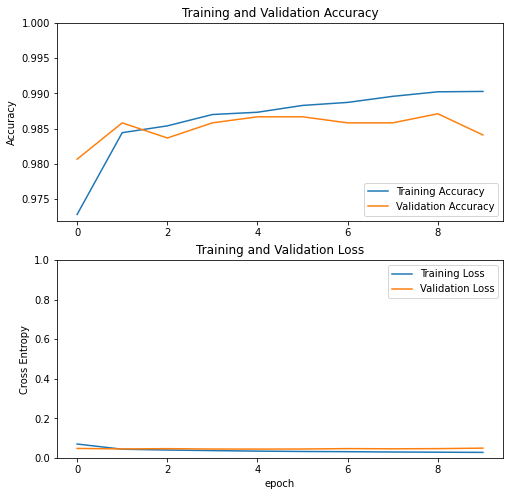

In [0]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
#Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

# To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.


In [0]:
# we use fine tuning

In [0]:
base_model.trainable = True

In [0]:
len(base_model.layers)

155

In [0]:
# fine tune at this layer onwards
fine_tune = 100

In [0]:
for layer in base_model.layers[:fine_tune]:
    layer.trainable = False

In [0]:
model.compile(optimizer = 'rmsprop', loss = tf.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [0]:
len(model.trainable_variables)

58

In [0]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
hist_fine = model.fit(train_batches, epochs = total_epochs, initial_epoch = hist.epoch[-1], validation_data = validation_batches)

Epoch 10/20
582/582 [==============================] - 95s 164ms/step - loss: 0.1551 - accuracy: 0.9451 - val_loss: 13.1115 - val_accuracy: 0.5189
Epoch 11/20
582/582 [==============================] - 96s 165ms/step - loss: 0.0833 - accuracy: 0.9707 - val_loss: 0.8873 - val_accuracy: 0.8805
Epoch 12/20
582/582 [==============================] - 92s 158ms/step - loss: 0.0587 - accuracy: 0.9813 - val_loss: 0.9053 - val_accuracy: 0.8796
Epoch 13/20
582/582 [==============================] - 94s 161ms/step - loss: 0.0422 - accuracy: 0.9861 - val_loss: 27.9606 - val_accuracy: 0.5370
Epoch 14/20
582/582 [==============================] - 87s 150ms/step - loss: 0.0310 - accuracy: 0.9904 - val_loss: 10.8663 - val_accuracy: 0.6513
Epoch 15/20
582/582 [==============================] - 89s 153ms/step - loss: 0.0252 - accuracy: 0.9926 - val_loss: 1.7813 - val_accuracy: 0.9123
Epoch 16/20
582/582 [==============================] - 93s 160ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.900

In [0]:
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

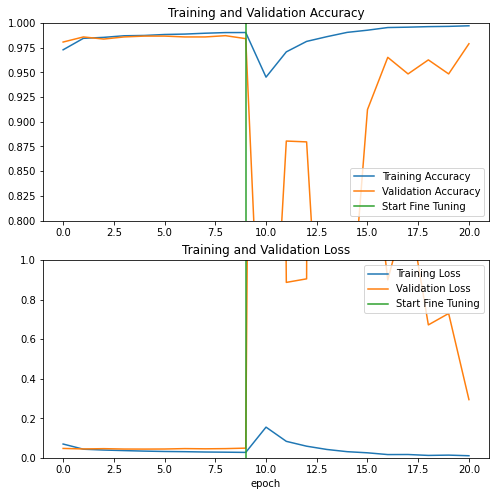

In [0]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()